# Kmer frequency Bacillus

Generate code to embed Bacillus sequences by calculating kmer frequency

import to note that this requires biopython version 1.77. Alphabet was deprecated in 1.78 (September 2020). Alternatively we could not reduce the alphabet though the kmer frequency table is sparse so could be a computational nightmare. 

Using the murphy10 reduced alphabet. There are other amino acid reduced alphabets could be tried as well https://biopython.org/docs/1.75/api/Bio.Alphabet.Reduced.html

Sequences containing 'X' have been excluded. The murphy10 alphabet has been used with options to try alphabets with a different number of amino acids. Sequeces longer than 1024 amino acids are also excluded. 

In [1]:
#imports 
import numpy as np 
import pandas as pd
from Bio.Seq import Seq
from Bio import Alphabet
from Bio.Alphabet import Reduced
import itertools
from Bio import SeqIO
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from matplotlib import pyplot as plt
from collections import Counter
import seaborn as sns
from sklearn.utils.extmath import randomized_svd 
from scipy.spatial import distance 
import random

In [2]:
def seq_3mers(sequence): 
    """Takes a sequence to overlapping 3-mers"""
    
    seq_size = len(sequence) 
    seq_3mers = list() #intialise list 
    
    #iterate through sequence to obtain 3mers 
    for i in range (1,seq_size-1):
        seq_3mers.append(sequence[i-1]+sequence[i]+sequence[i+1])
        
    return seq_3mers

def murphy10(seq_str): 
    """Takes an amino acid sequence using the standard 20 amino acid code to reduced 10 letter alphabet. 
        This funcseqs_swiss_keystion requires biopython version 1.77 or lower. Input is a a string of amino acids"""
    
    #turn starting sequence into a sequence object 
    intial_seq = Seq(seq_str, Alphabet.ProteinAlphabet())
    
    #intialise sequence object 
    new_seq = Seq('', Alphabet.Reduced.Murphy10())
    
    #iterate through the letters in the sequence and convert to murphy10 
    for aa in intial_seq: 
        new_seq += Alphabet.Reduced.murphy_10_tab[aa]
    
    return str(new_seq)

def seq_vector(seq, embedding): 
    """Embeds a sequence as a kmer frequency embedding"""
    
    #break the seq into kmers 
    seq_kmers = seq_3mers(seq)
    
    #intialise a vector for the sequence to be embedded 
    seq_vec = np.zeros(len(embedding))
    
    #iterate through the kmers in the sequence 
    for kmer in seq_kmers: 
        
        #add the kmer vector to make the sequence vector 
        seq_vec += embedding[kmer]
        
    #divide the sequence by the number of kmers (number of kmer counts) (NOT SURE IF THIS IS CORRECT - PLAY AROUND WITH this)
    seq_vec = seq_vec/len(seq_kmers)
    
    return seq_vec  

def embedkmers_seqs(seqs, embedding): 
    """Embed a list of sequences with a dataframe of kmer frequency"""
    
    #intialise an array to hold the embeddings
    embed_kmerfreq = np.zeros((len(seqs), len(embedding)))
    
    #iterate through the sequences 
    for i in range(len(seqs)): 
        #get the sequence 
        seq = seqs[i]
        
        #get the vector
        seq_vec= seq_vector(seq, embedding)
        
        #add the sequnce vector to the embeddings matrix 
        embed_kmerfreq[i] = seq_vec 
        
    return embed_kmerfreq 
    

In [3]:
#import the embedding sequences 
embed_seqs_dict = SeqIO.index("../../sequences/bacillus_embeddingset.fa", 'fasta')
embed_seqs_keys = list(embed_seqs_dict.keys()) #gives md5 hashes of the sequences 
embed_seqs = [str(embed_seqs_dict.get(key).seq) for key in embed_seqs_keys]

#get a random subset of 16763 sequences to embed (this was the number of sequences embedded for bacteroides)
randint = random.sample(range(len(embed_seqs)), 16763) 
embed_seqs_keys = embed_seqs_keys

#determine which sequences contain the invalid character 'X' and remove them from the set of sequences to embed 
embed_seqs_containsX = ['X' not in seqs for seqs in embed_seqs]
keys_containsX = [embed_seqs_keys[i] for i in range(len(embed_seqs_keys)) if embed_seqs_containsX[i] == True]
embed_seqs = [str(embed_seqs_dict.get(key).seq) for key in keys_containsX]
embed_seqs_keys = keys_containsX 

#remove sequences which contain more than 1024 amino acids 
embed_seqs_1024 = [len(seqs)<= 1024 for seqs in embed_seqs]
keys_1024 = [embed_seqs_keys[i] for i in range(len(embed_seqs)) if embed_seqs_1024[i] == True]
embed_seqs = [str(embed_seqs_dict.get(key).seq) for key in keys_1024]
embed_seqs_keys = keys_1024

#generate a list of all possible kmeres for the murphy10 alphabet 
murphy10_sub = Alphabet.Reduced.murphy_10_tab 
murphy10_l = set([d[1] for d in list(murphy10_sub.items())]) #list of letters in the murphy10 alphabet  
k = 3 #intialise the length of the kmer 
kmers = [''.join(kmer) for kmer in list(itertools.product(murphy10_l, repeat = k))]

#intialise idnetity matrix size of kmers to represent the kmer embedding (each 1 is denotes a different kmer)
kmerfreq = np.identity(len(kmers))
#represent as a dataframe 
kmerfreq_df = pd.DataFrame(kmerfreq) 
kmerfreq_df.columns = kmers
kmerfreq_df.index = kmers

#convert the embedded sequences to murphy 10 
embed_seqs_murphy10 = [murphy10(seq) for seq in embed_seqs]
#embed the sequences 
embed_kmerfreq = embedkmers_seqs(embed_seqs_murphy10, kmerfreq_df)

In [4]:
#read in the ontology info and filter out the sequences we choose to ignore 
#need to read in some file which will map the sequences to the known hierachical classification (KEGG, Subsystems)
sub_sys = pd.read_csv('../../subsystems_labels/bacillus.ids.tsv', sep = '\t', header = None)
sub_sys.columns =  ['fig_ID', 'species', 'superclass', 'class', 'subclass', 'subsystem', 'product role_name']

#get the file which takes the md5 hashes to the fig IDs 
md5_fig = pd.read_csv('../../subsystems_labels/bacillus.md5.ids', sep = '\t', header = None)
md5_fig.columns = ['md5', 'fig_ID']

#assemble as a dictionary which takes a seqence key to the ontological represenation 
seqs_keys_figID = pd.concat([md5_fig[md5_fig['md5'] == key] for key in embed_seqs_keys])

#convert the embedded sequences to murphy 10 
embed_seqs_murphy10 = [murphy10(seq) for seq in embed_seqs]
embed_kmerfreq = embedkmers_seqs(embed_seqs_murphy10, kmerfreq_df)

In [5]:
#make dictionaries for subclass/superclass but this time include the entry 'dual'
fig2subclass = sub_sys[['fig_ID', 'subclass']].drop_duplicates()
fig2subsystem = sub_sys[['fig_ID', 'subsystem']].drop_duplicates()

#change fig_IDs which have more than one subclass to 'dual'
duplicate_subclasses = pd.DataFrame(fig2subclass['fig_ID'].value_counts())
duplicate_subclasses = duplicate_subclasses[duplicate_subclasses['fig_ID'] > 1].index.values
duplicate_removed_subclasses = fig2subclass[~fig2subclass['fig_ID'].isin(duplicate_subclasses)]

dual_vec = ['dual' for i in range(0,len(duplicate_subclasses))]
dual_subclasses = pd.DataFrame({'fig_ID': duplicate_subclasses, 'subclass': dual_vec})
fig2subclass = pd.concat([duplicate_removed_subclasses, dual_subclasses], axis = 0)

#change fig_IDs which have more than one subsystem to 'dual'
duplicate_subsystems = pd.DataFrame(fig2subsystem['fig_ID'].value_counts())
duplicate_subsystems = duplicate_subsystems[duplicate_subsystems['fig_ID'] > 1].index.values
duplicate_removed_subsystems = fig2subsystem[~fig2subsystem['fig_ID'].isin(duplicate_subsystems)]

dual_vec = ['dual' for i in range(0,len(duplicate_subsystems))]
dual_subsystems = pd.DataFrame({'fig_ID': duplicate_subsystems, 'subsystem': dual_vec})
fig2subsystem = pd.concat([duplicate_removed_subsystems, dual_subsystems], axis = 0)

#make these dataframes into dictionaries 
subclass_dict = dict(zip(fig2subclass['fig_ID'].values, fig2subclass['subclass'].values))
subsystem_dict = dict(zip(fig2subsystem['fig_ID'].values, fig2subsystem['subsystem'].values))

#add columns to dataframes for the subsystem and subclasses 
seqs_keys_figID['Subsystem'] = [subsystem_dict.get(fig_id) for fig_id in seqs_keys_figID['fig_ID']]
seqs_keys_figID['Subclass'] = [subclass_dict.get(fig_id) for fig_id in seqs_keys_figID['fig_ID']]

#collapse by subclass and subsystem 
seqs_subclass = seqs_keys_figID[['md5', 'Subclass']].drop_duplicates()
seqs_subsystem = seqs_keys_figID[['md5', 'Subsystem']].drop_duplicates()

seqs_subsystem = seqs_keys_figID[['md5', 'Subsystem']].drop_duplicates()
seqs_subsystem_count = Counter(seqs_subsystem['md5'].values)
count_df = pd.DataFrame.from_dict(seqs_subsystem_count, orient='index').reset_index()
duplicates = count_df[count_df[0]>1] #this gives the 2 sequences with duplicates
duplicates_md5 = duplicates['index'].values
duplicates_df = seqs_subsystem[seqs_subsystem['md5'].isin(duplicates_md5)]
duplicates_idx = duplicates_df[duplicates_df['Subsystem'] != 'dual'].index.values

seqs_subsystem = seqs_subsystem.drop(duplicates_idx)

seqs_subclass = seqs_subclass.replace('dual', 'CO2 fixation and C-1 compound metabolism')
cmap = ('#a6cee3', '#1f78b4', '#b2df8a', '#33a02c', '#fb9a99', '#e31a1c', '#fdbf6f', '#ff7f00', '#cab2d6', '#6a3d9a' ) #colour map for the plots 

In [6]:
#save the embedding - useful to save as can take a long time to run 
embed_kmerfreqDf = pd.DataFrame(embed_kmerfreq, index = embed_seqs_keys)
embed_kmerfreqDf.columns = kmers
embed_kmerfreqDf.to_csv('kmer_frequency_bacillus.csv')

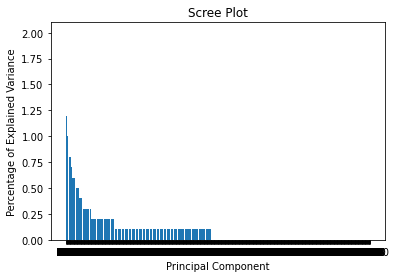

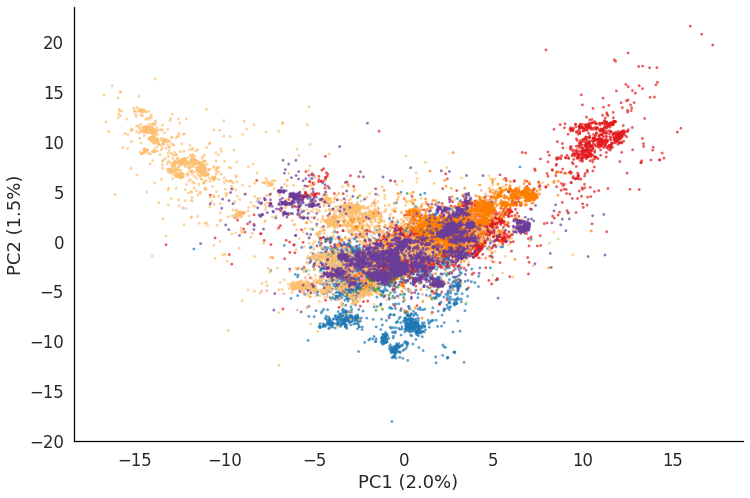

In [7]:
#do the PCA 
embedding_scaled = StandardScaler().fit_transform(embed_kmerfreq)

pca = PCA()
embedding_pca = pca.fit_transform(embedding_scaled)

#do the scree plot - see how the PCA went 
per_var = np.round(pca.explained_variance_ratio_* 100, decimals=1)
labels = ['PC' + str(x) for x in range(1, len(per_var)+1)]
plt.bar(x=range(1,len(per_var)+1), height=per_var, tick_label=labels)
plt.ylabel('Percentage of Explained Variance')
plt.xlabel('Principal Component')
plt.title('Scree Plot')
plt.show()

#plot the PCA 
labels = ['PC' + str(x) for x in range(1, len(per_var)+1)]
pca_df = pd.DataFrame(embedding_pca, columns=labels)
pca_df.index = embed_seqs_keys
pca_df['Subclass'] = seqs_subclass['Subclass'].values

#sort the pca df by the subclass labels - allows to keep colours consistent between models 
pca_df = pca_df.sort_values('Subclass')

#get the labels for the plot 
x_label = 'PC1 ('+str(np.round(per_var[0],2))+"%)"
y_label = 'PC2 ('+str(np.round(per_var[1],2))+"%)"

sns.set(font_scale = 1.5)
fig, ax = plt.subplots(1, 1, figsize = (12,8))
ax.set_facecolor('white')
plt.xlabel(x_label, fontsize = 18)
plt.ylabel(y_label, fontsize = 18)
sns.scatterplot(x = 'PC1', y = 'PC2', hue = 'Subclass',data = pca_df, legend = 'full', s = 8,linewidth=0, alpha = 0.7, palette = cmap)
ax.spines['left'].set_color('black')
ax.spines['bottom'].set_color('black')
plt.legend([],[], frameon=False)

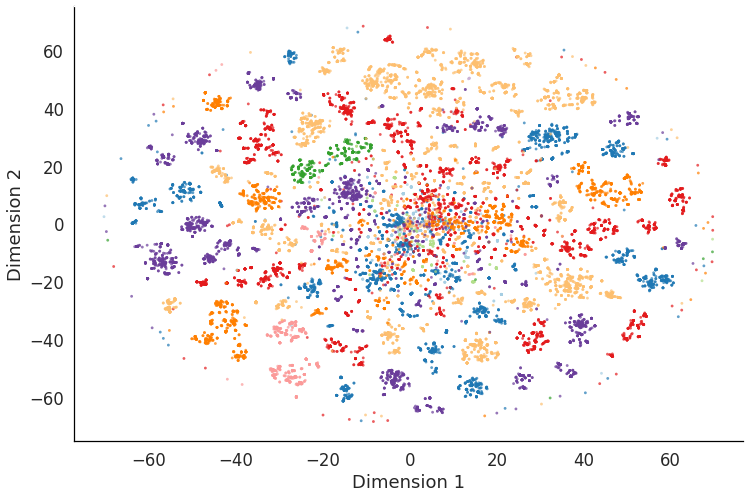

In [8]:
#do the tSNE
tsne = TSNE(perplexity = 50, learning_rate = 100)
embedding_tsne = tsne.fit_transform(embedding_scaled)

#plot it scatter plot 
tsne_df = pd.DataFrame(embedding_tsne, columns = ['Dimension 1', 'Dimension 2'])
tsne_df.index = embed_seqs_keys

#colour by subclass 
tsne_df['Subclass'] = seqs_subclass['Subclass'].values

#sort so that the colouring is consistent 
tsne_df = tsne_df.sort_values('Subclass')

sns.set(font_scale = 1.5)
fig, ax = plt.subplots(1, 1, figsize = (12,8))
ax.set_facecolor('white')
plt.xlabel('Dimension 1', fontsize = 18)
plt.ylabel('Dimension 2', fontsize = 18)
sns.scatterplot(x = 'Dimension 1', y = 'Dimension 2', hue = 'Subclass',data = tsne_df, s = 8,linewidth=0, alpha = 0.7, palette = cmap)
ax.spines['left'].set_color('black')
ax.spines['bottom'].set_color('black')
plt.legend([],[], frameon=False)

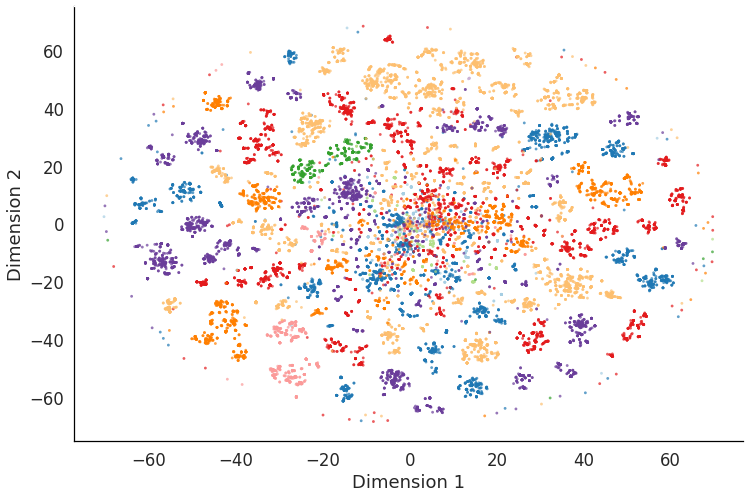

In [9]:
tsne_df = pd.DataFrame(embedding_tsne, columns = ['Dimension 1', 'Dimension 2'])

#colour by subclass 
tsne_df['Subclass'] = seqs_subclass['Subclass'].values
tsne_df.index = embed_seqs_keys

#sort so that the colouring is consistent 
tsne_df = tsne_df.sort_values('Subclass')


sns.set(font_scale = 1.5)
fig, ax = plt.subplots(1, 1, figsize = (12,8))
ax.set_facecolor('white')
plt.xlabel('Dimension 1', fontsize = 18)
plt.ylabel('Dimension 2', fontsize = 18)
sns.scatterplot(x = 'Dimension 1', y = 'Dimension 2', hue = 'Subclass',data = tsne_df, s = 8,linewidth=0, alpha = 0.7, palette = cmap)
ax.spines['left'].set_color('black')
ax.spines['bottom'].set_color('black')
plt.legend([],[], frameon=False)